In [1]:
from fastai.data.all import *
from fastai.vision.all import *
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.data.las import *
from enveco.model.ensemble import *
from enveco.interpretation import *
from enveco.model.alexnet import *
from enveco.metrics import *
from fastai.callback.progress import ShowGraphCallback

# Read data

Read field plot data used for training and validation

In [2]:
basedir = Path('../../../andras/ml/AV_leafon/')

train_df = pd.read_csv(basedir/'AV.leaf.on.train.csv')
valid_df = pd.read_csv(basedir/'AV.leaf.on.val.csv')
train_df['is_val'] = False
valid_df['is_val'] = True

df = pd.concat((train_df, valid_df))

df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v.ma,v.ku,v.lp,myear,filename.1,a.date.1,a.window.1,filename.2,a.date.2,a.window.2,v.lp.proc,is_val
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,False
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,False
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,False
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,False
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,False


Create `VoxelDataLoaders` from dataframe.

* `bin_voxels` controls whether to set all voxels to be either 0 or 1
* `mask_plot` controls whether to mask all locations outside 9m radius from center
* `bottom_voxels` controls whether to fill all voxels under any detected voxel

`DihedralItem` provides on-the-fly rotations as augmentations.

In [3]:
#export

class VoxelTo2D(Transform):
    "Transforms batch of 3D images to 2D images"
    order = 99
    
    def __init__(self, split_idx=None):
        super().__init__(split_idx=split_idx)
        
    def encodes(self, o:TensorImage):  
         return o[:,0]
    def decodes(self, o:TensorImage): 
         return o[:,None]

In [19]:
target='v'
dls = VoxelDataLoaders.from_df(df, path=basedir, folder='AV_las/', 
                               bin_voxels=True, 
                               bottom_voxels=False, 
                               mask_plot=False,
                               y_block=RegressionBlock(), 
                               label_col=target, fn_col='sampleplotid', bs=32,
                               batch_tfms=[DihedralItem, VoxelTo2D],
                               valid_col='is_val')

In [5]:
dls.one_batch()

(VoxelImage size=32x105x40x40,
 tensor([ 40.9500, 209.6200, 249.9600,  59.5600, 156.1100,  44.4400, 122.2300,
         176.1000, 125.6500,  69.8500, 104.5600, 236.2500, 130.9900, 232.7100,
         106.5000,  60.5400, 152.8700,  90.8000, 112.3200, 108.0500, 103.5600,
          39.4800,  84.5400, 145.4900,  96.2200, 122.2600, 175.2400, 246.9900,
         177.0200,  50.1800, 101.9300, 175.0800], device='cuda:0'))

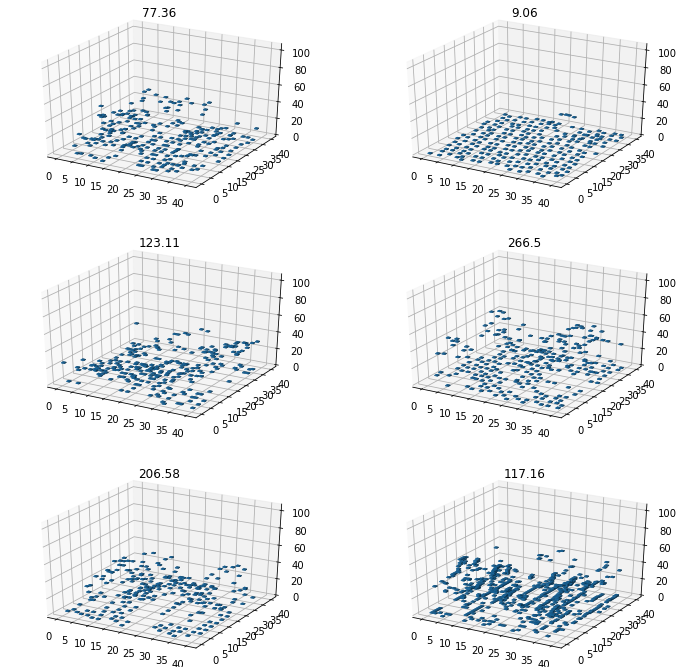

In [6]:
dls.show_batch()

# Learner

Set metrics to use

In [6]:
metrics = [rmse, rrmse, bias, bias_pct, mae, R2Score()]

Create learner

In [7]:
learn = alexnetvoxel_learner(dls, metrics=metrics, path='.', y_range=(0, train_df['v'].max()*1.1), n_in=105)

In [8]:
learn.summary()

AlexNetVoxel (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 1050 x 40 x 40 
Conv2d                                    441000     True      
BatchNorm2d                               2100       True      
____________________________________________________________________________
                     []                  
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 256 x 20 x 20  
Conv2d                                    2419200    True      
BatchNorm2d                               512        True      
____________________________________________________________________________
                     []                  
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 384 x 10 x 10  
Con

In [9]:
apply_init(learn.model)

SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=7.585775847473997e-07)

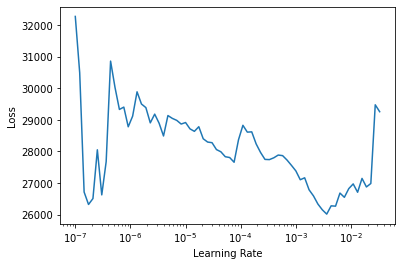

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,25203.683594,74736.078125,273.378998,181.323547,-263.230713,-174.592499,263.230682,-7.212032,00:02
1,23663.943359,26826.892578,163.789169,108.636116,-156.833023,-104.022331,156.833008,-1.947750,00:02
2,23010.005859,17099.304688,130.764313,86.731789,-124.921898,-82.856697,125.523170,-0.878879,00:02
3,22505.533203,28146.207031,167.768311,111.275352,62.912128,41.727604,124.574142,-2.092717,00:02
4,17206.210938,7191.133301,84.800552,56.245495,14.688729,9.742564,58.126484,0.209835,00:02
5,10581.132812,5954.595703,77.166031,51.181759,62.067764,41.167561,63.418259,0.345706,00:02
6,6578.761230,1818.715942,42.646404,28.285995,19.722012,13.080979,31.710052,0.800159,00:02
7,4634.800293,7662.220215,87.534111,58.058578,36.399582,24.142679,58.107697,0.158072,00:02
8,3233.557861,2125.674072,46.105034,30.579992,-3.377795,-2.240383,35.649368,0.766430,00:02
9,2570.474609,2947.210938,54.288223,36.007645,2.339542,1.551743,34.186077,0.676159,00:02


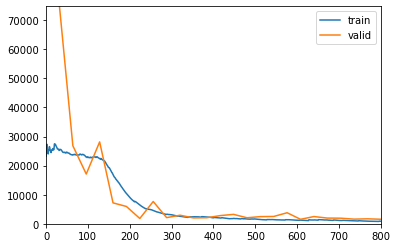

In [12]:
learn.fit_one_cycle(25, lr_max=1e-3, cbs=ShowGraphCallback())

# See results

In [13]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

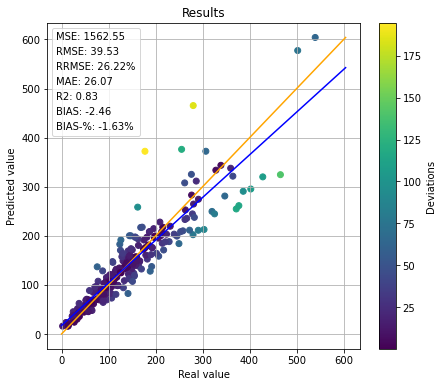

In [14]:
reg_interp.plot_results()
plt.show()

In [15]:
test_df = pd.read_csv(basedir/'AV.leaf.on.test.csv')

In [16]:
test_dl = learn.dls.test_dl(test_df, with_labels=True)


In [17]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dl)

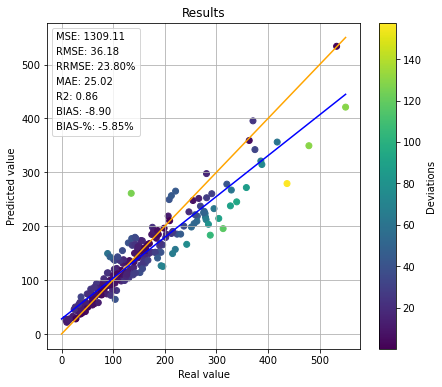

In [18]:
test_interp.plot_results()
plt.show()

In [20]:
learn.export(f'models/alexnet_{target}.pkl')

# Resnet 50

In [30]:
resnet = cnn_learner(dls, vgg16_bn, pretrained=True, 
                    #metrics=[accuracy_multi, f1_multi, pre_multi, rec_multi], 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                    #metrics = [accuracy, Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')], loss_func=LabelSmoothingCrossEntropy(),
                    y_range=(0, train_df[target].max()*1.1), n_in=105,
                    path='.', model_dir='models')

In [31]:
resnet.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 40 x 40   
Conv2d                                    60544      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 20 x 20  
Conv2d                                    73856      True      
BatchNorm2d                               256        True      
ReLU                                                           
Conv2d                                    147584     True      
BatchNorm2d                               

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.013182567432522774)

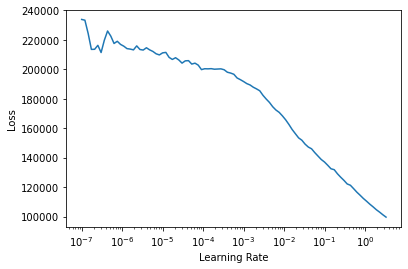

In [32]:
apply_init(resnet.model)
resnet.lr_find()

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,108152.343750,654418.000000,808.961121,536.558044,803.316406,532.814087,803.316406,-70.907736,00:02
1,78344.437500,110081.726562,331.785675,220.062836,136.303345,90.405647,262.666107,-11.095828,00:02
2,55376.007812,190963.484375,436.993683,289.843933,297.439667,197.282211,347.221436,-19.983150,00:02
3,48463.312500,440553.718750,663.742188,440.238953,498.483856,330.628418,563.001526,-47.408228,00:02
4,31023.863281,14680.101562,121.161476,80.362526,-73.694580,-48.879257,87.708969,-0.613056,00:02
5,22958.996094,22270.455078,149.232895,98.981407,-121.539268,-80.613106,123.229156,-1.447088,00:02
6,16179.372070,12403.291992,111.370071,73.868202,-83.185837,-55.174507,85.489960,-0.362879,00:02
7,11810.702148,7568.831055,86.999031,57.703674,-22.343391,-14.819656,63.641506,0.168333,00:02
8,14749.760742,31789.117188,178.295029,118.257393,-150.470871,-99.802513,150.470886,-2.493002,00:02
9,14504.673828,50342.589844,224.371552,148.818466,171.960800,114.056099,198.791168,-4.531665,00:02


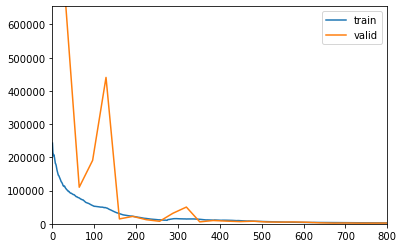

In [33]:
resnet.fit_one_cycle(25, lr_max=1e-2, cbs=ShowGraphCallback())

In [34]:
reg_interp = RegressionInterpretation.from_learner(resnet, ds_idx=1)

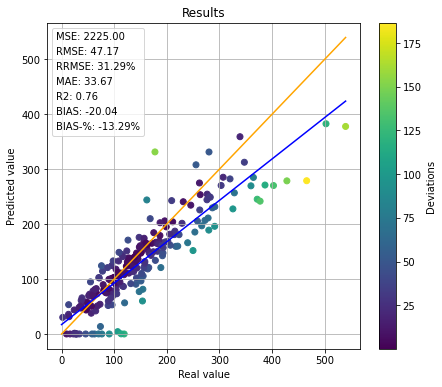

In [35]:
reg_interp.plot_results()
plt.show()

In [36]:
test_interp = RegressionInterpretation.from_learner(resnet, dl=test_dl)

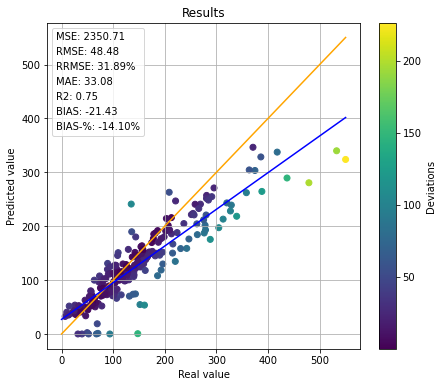

In [37]:
test_interp.plot_results()
plt.show()